In [1]:
import sys
import os

import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm


In [2]:
import fiona

# to see if FlatGeoBuf is already supported in your Python env, if not choose the GPKG files, try with QGIS as well for fun :-)
fiona.supported_drivers

{'ARCGEN': 'r',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'rw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

In [3]:
# world_countries NaturalEarth\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp
world_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [75]:
# FlatGeoBuf is a new and very compact vector format, a little experimental and really only supported since a year or max. two
# so I provide FlatGeoBuf (fgb) and geopackage for same

# attributes:
# crossed - true/false if crossed the dateline, can't plot those correctly in most GIS tools
# area - m2
# perimeter - m2
# ipq - "standard compactness",  isoperimetric inequality (IPQ) Ossermann 1978 
# zsc - Zone standardised compactness (ZSC) - on the sphere, don't use, I left it in
# lon - longitude of cell centroid
# lat - latitude of cell centroid

print_data = [
'DGGRID_FULLER3H_6_LAEA_step2.fgb',
'DGGRID_FULLER4D_6_LAEA_step2.fgb', # (4,5?)
'DGGRID_FULLER4T_5_LAEA_step2.fgb',
'DGGRID_FULLER7H_4_LAEA_step2.fgb',
'DGGRID_ISEA3H_6_LAEA_step2.fgb',
'DGGRID_ISEA4D_6_LAEA_step2.fgb',
'DGGRID_ISEA4T_5_LAEA_step2.fgb',
'DGGRID_ISEA7H_4_LAEA_step2.fgb',
'eaggr_ISEA3H_3_LAEA_step2.fgb', # (probably rubbish and duplicates)
'eaggr_ISEA4T_5_LAEA_step2.fgb',
'h3_3_LAEA_step2.fgb',
'rhpix_4_LAEA_step2.fgb',
's2_6_LAEA_step2.fgb'
]

datafile = print_data[0]

In [76]:
grid = gpd.read_file("../results_gen_bak/" + datafile)

grid[["perimeter", "area", "ipq"]].describe()

,perimeter,area,ipq
count,7.292000e+03,7.292000e+03,7292.000000
mean,9.928370e+05,6.994079e+10,0.898241
std,9.953315e+04,2.228419e+09,0.043993
min,8.285571e+05,4.724398e+10,0.053294
25%,9.776813e+05,6.839600e+10,0.899747
50%,9.873839e+05,6.990686e+10,0.901643
75%,9.982901e+05,7.165255e+10,0.903846
max,3.942821e+06,7.413314e+10,0.906871


In [77]:
grid.sample(5)

,cell_id,crossed,area,perimeter,ipq,zsc,lon,lat,geometry
6880,4802,False,7.205028e+10,1.000926e+06,0.903736,0.950584,-22.270384,-45.219894,"POLYGON ((-20.20107 -44.73974, -21.63988 -43.7..."
3507,1939,False,6.998795e+10,9.876312e+05,0.901661,0.949494,23.604885,6.972201,"POLYGON ((24.92007 7.73131, 23.75696 8.51523, ..."
964,1795,False,6.859837e+10,9.776727e+05,0.901855,0.949597,6.474739,-2.336384,"POLYGON ((7.68834 -1.55487, 6.52648 -0.77673, ..."
6315,1487,False,6.526429e+10,9.537373e+05,0.901629,0.949481,-19.789727,-2.084968,"POLYGON ((-18.40501 -1.49780, -19.43936 -0.746..."
5414,6902,False,7.073435e+10,9.915442e+05,0.904099,0.950775,-168.750000,7.020113,"POLYGON ((-167.50585 7.79737, -168.75000 8.577..."


In [78]:
# remove bogus cells for nice plotting
grid = grid[~grid['crossed']].dropna(subset=["perimeter", "area", "ipq"])

grid[["perimeter", "area", "ipq"]].describe()

,perimeter,area,ipq
count,7.206000e+03,7.206000e+03,7206.000000
mean,9.873412e+05,6.995066e+10,0.901433
std,1.440830e+04,2.232852e+09,0.003597
min,8.285571e+05,4.724398e+10,0.864792
25%,9.775934e+05,6.840057e+10,0.899830
50%,9.873693e+05,6.992425e+10,0.901654
75%,9.981951e+05,7.166099e+10,0.903883
max,1.013534e+06,7.413314e+10,0.906871


In [79]:
# for the normalised area
grid['norm_area'] = grid['area']/grid['area'].mean()

In [80]:
grid[["perimeter", "area", "ipq", "norm_area"]].describe()

,perimeter,area,ipq,norm_area
count,7.206000e+03,7.206000e+03,7206.000000,7206.000000
mean,9.873412e+05,6.995066e+10,0.901433,1.000000
std,1.440830e+04,2.232852e+09,0.003597,0.031920
min,8.285571e+05,4.724398e+10,0.864792,0.675390
25%,9.775934e+05,6.840057e+10,0.899830,0.977840
50%,9.873693e+05,6.992425e+10,0.901654,0.999622
75%,9.981951e+05,7.166099e+10,0.903883,1.024450
max,1.013534e+06,7.413314e+10,0.906871,1.059792


In [81]:
grid.loc[grid["norm_area"] > 1.3]

,cell_id,crossed,area,perimeter,ipq,zsc,lon,lat,geometry,norm_area


In [82]:
grid.loc[grid["norm_area"] < 0.5]

,cell_id,crossed,area,perimeter,ipq,zsc,lon,lat,geometry,norm_area


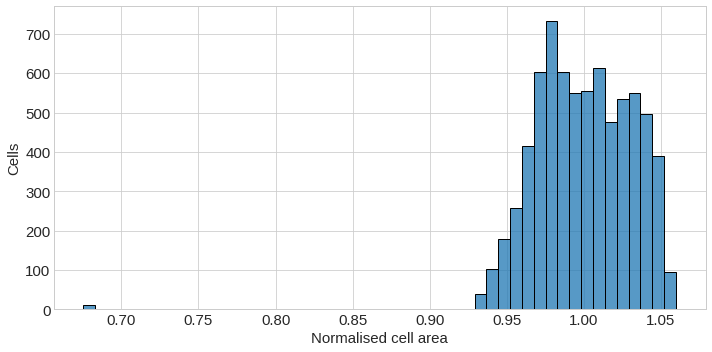

In [83]:
# the normalised area histograms
fig, ax = plt.subplots(figsize=(10,5))

# there are outliers, presumably from wrong calculation for dateline crossed cells
sns.histplot(grid[~grid['crossed']],x="norm_area", ax=ax, bins=50, palette="deep")

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Normalised cell area', fontsize=15)
ax.set_ylabel('Cells', fontsize=15)
plt.tight_layout()
# plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_area.png', bbox_inches="tight",dpi=300)

0.6753899839404934
1.059791752600295
[0.5        0.51355932 0.52711864 0.54067797 0.55423729 0.56779661
 0.58135593 0.59491525 0.60847458 0.6220339  0.63559322 0.64915254
 0.66271186 0.67627119 0.68983051 0.70338983 0.71694915 0.73050847
 0.7440678  0.75762712 0.77118644 0.78474576 0.79830508 0.81186441
 0.82542373 0.83898305 0.85254237 0.86610169 0.87966102 0.89322034
 0.90677966 0.92033898 0.93389831 0.94745763 0.96101695 0.97457627
 0.98813559 1.00169492 1.01525424 1.02881356 1.04237288 1.0559322
 1.06949153 1.08305085 1.09661017 1.11016949 1.12372881 1.13728814
 1.15084746 1.16440678 1.1779661  1.19152542 1.20508475 1.21864407
 1.23220339 1.24576271 1.25932203 1.27288136 1.28644068 1.3       ]
13
41
[13 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 22 23 23
 24 24 25 25 26 26 27 27 28 28 29 29 30 30 31 31 31 32 32 33 33 34 34 35
 35 36 36 37 37 38 38 39 39 40 40 41]


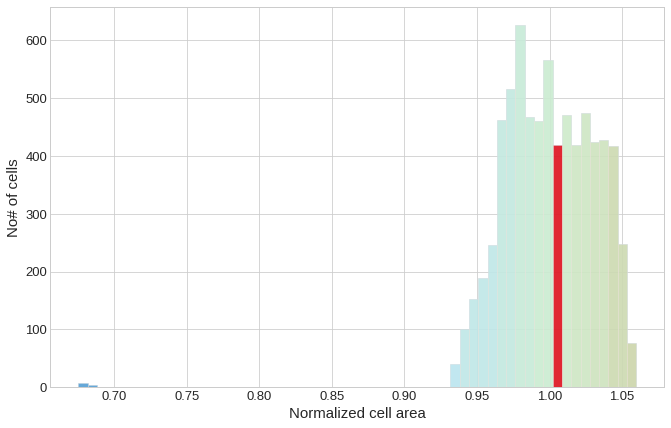

In [103]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
def find_nearest(array, value, as_idx=False):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if as_idx:
        return idx
    else:
        return array[idx]


# the normalised area histograms
fig, ax = plt.subplots(figsize=(11,7))

# there are outliers, presumably from wrong calculation for dateline crossed cells
patches = plt.hist(data=grid,x="norm_area", bins=60, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
plt.style.use('seaborn-whitegrid')

n, bins, patches = plt.hist(data=grid[~grid['crossed']],x="norm_area", bins=60, edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') # it MUST be integer

bin_df = pd.DataFrame({ "bin_vals": np.abs(1-bins)})
min_idx = bin_df.loc[bin_df["bin_vals"] == bin_df["bin_vals"].min()].index[0]

vmin, vmax, vcenter = 0.5, 1.3, 1
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

spec_cmap = cm.get_cmap('RdYlBu_r', len(n))
norm_cmap = spec_cmap(norm(np.linspace(vmin, vmax, len(n))))

a_vmin = bins.min()
a_vmax = bins.max()
print(a_vmin)
print(a_vmax)

syn_list = np.linspace(vmin, vmax, len(n))

print(syn_list)

cut_vmin = find_nearest(syn_list, a_vmin, as_idx=True)
cut_vmax = find_nearest(syn_list, a_vmax, as_idx=True)

print(cut_vmin)
print(cut_vmax)

act_list = np.linspace(cut_vmin, cut_vmax, len(n)).astype(int)
print(act_list)

# Good old loop. Choose colormap of your taste
# spec_cmap(  bins[i] / max(bins))
for i in range(len(patches)):
    patches[i].set_facecolor(norm_cmap[act_list[i]])
# Make one bin stand out   
patches[min_idx].set_fc('red') # Set color
patches[min_idx].set_alpha(0.8) # Set opacity

# Add annotation
plt.annotate('no distortion', xy=(1.0, 1300), xytext=(1.1, 1500), fontsize=12, arrowprops={'width':0.3,'headwidth':6,'color':'#333333'})
#plt.title(title') 

plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlabel('Normalized cell area', fontsize=15) 
plt.ylabel('No# of cells', fontsize=15) 
plt.show()
# plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_area.png', bbox_inches="tight",dpi=300)

In [64]:
norm(np.linspace(0.5, 1.3, 60))

masked_array(data=[0.        , 0.01355932, 0.02711864, 0.04067797,
                   0.05423729, 0.06779661, 0.08135593, 0.09491525,
                   0.10847458, 0.1220339 , 0.13559322, 0.14915254,
                   0.16271186, 0.17627119, 0.18983051, 0.20338983,
                   0.21694915, 0.23050847, 0.2440678 , 0.25762712,
                   0.27118644, 0.28474576, 0.29830508, 0.31186441,
                   0.32542373, 0.33898305, 0.35254237, 0.36610169,
                   0.37966102, 0.39322034, 0.40677966, 0.42033898,
                   0.43389831, 0.44745763, 0.46101695, 0.47457627,
                   0.48813559, 0.50282486, 0.52542373, 0.5480226 ,
                   0.57062147, 0.59322034, 0.61581921, 0.63841808,
                   0.66101695, 0.68361582, 0.70621469, 0.72881356,
                   0.75141243, 0.7740113 , 0.79661017, 0.81920904,
                   0.84180791, 0.86440678, 0.88700565, 0.90960452,
                   0.93220339, 0.95480226, 0.97740113, 1.     

In [101]:
np.linspace(cut_vmin, cut_vmax, len(n)).astype(int)

array([13, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20,
       21, 21, 22, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28,
       29, 29, 30, 30, 31, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36,
       37, 37, 38, 38, 39, 39, 40, 40, 41])

[0.58486146 0.65613969 0.47433481 0.47903664 0.92317172 0.35270995
 0.67170675 0.36287132 0.63027556 0.67418877]
3


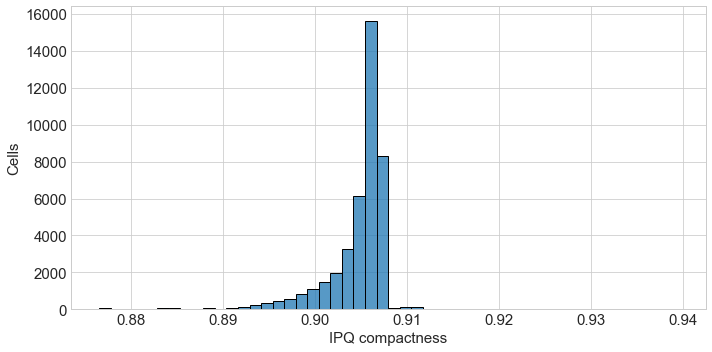

In [62]:
# the important IPQ compactness histograms
fig, ax = plt.subplots(figsize=(10,5))

# there are outliers, presumably from wrong calculation for dateline crossed cells
sns.histplot(grid[~grid['crossed']],x="ipq", ax=ax, bins=50)
# sns.histplot(grid,x="ipq", ax=ax, bins=50)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('IPQ compactness', fontsize=15)
ax.set_ylabel('Cells', fontsize=15)
plt.tight_layout()
# plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_compactness.png', bbox_inches="tight",dpi=300)

NameError: name 'world_countries' is not defined

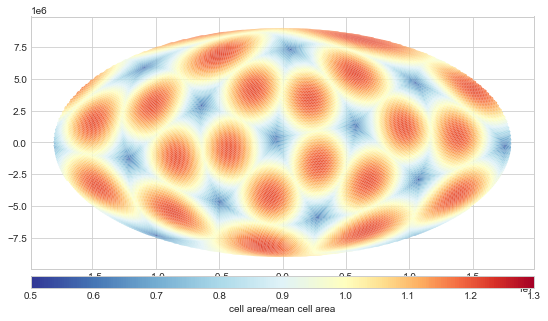

In [63]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# the vmin/vmax boundaries for all plots I have to determine based on the stats which I currently calculate
# vmin, vmax, vcenter = grid['norm_area'].min(), grid['norm_area'].max(), 1
vmin, vmax, vcenter = 0.5, 1.3, 1
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# plots get messed up for dateline crossed cells
grid[~grid['crossed']].to_crs('proj=moll').plot(column='norm_area', ax=ax, norm=norm, legend=True,cax=cax, cmap='RdYlBu_r', legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})
# grid.to_crs('proj=moll').plot(column='std_area', ax=ax, norm=norm, legend=True,cax=cax, cmap='RdYlBu_r', legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})

world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "Cell area/mean cell area",fontsize=14)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
# plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_area_map.png', bbox_inches="tight",dpi=300)


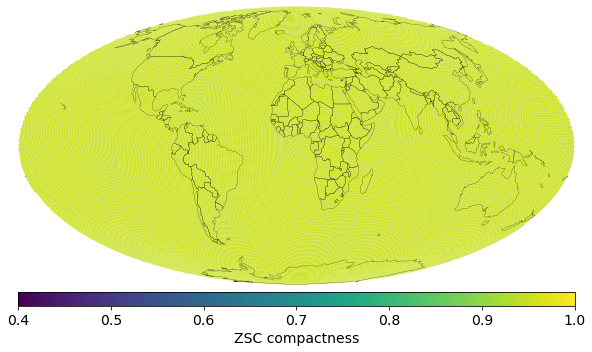

In [221]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

vmin = 0.4
vmax = 1.0

grid[~grid['crossed']].to_crs('proj=moll').plot(column='zsc', ax=ax, vmin=vmin, vmax=vmax, legend=True,cax=cax, legend_kwds={'label': "zonal standadized compactness",'orientation': "horizontal"})
# grid.to_crs('proj=moll').plot(column='zsc', ax=ax, legend=True,cax=cax, legend_kwds={'label': "zonal standadized compactness",'orientation': "horizontal"})

world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "ZSC compactness",fontsize=14)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
# plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_compactness_map.png', bbox_inches="tight",dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

grid[~grid['crossed']].to_crs('proj=moll').plot(column='ipq', ax=ax, vmin=vmin, vmax=vmax, legend=True,cax=cax, legend_kwds={'label': "IPQ compactness",'orientation': "horizontal"})
# grid.to_crs('proj=moll').plot(column='zsc', ax=ax, legend=True,cax=cax, legend_kwds={'label': "zonal standadized compactness",'orientation': "horizontal"})

world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "IPQ compactness",fontsize=14)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
# plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_compactness_map.png', bbox_inches="tight",dpi=300)